In [19]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os as os
import matplotlib.pyplot as plt

# own code base
import sys

sys.path.append("..")
import tf_loss_functions as lf
import splines as sp

In [20]:
basis_dimension = 20
degree_bsplines = 3
penalty_diff_order = 2


zambia = pd.read_table("Data/zambia_height92.txt")

c_breastf_d = zambia.loc[:, "c_breastf"]
c_age_d = zambia.loc[:, "c_age"]
labels = zambia.loc[:, "zscore"]
labels_expanded = np.expand_dims(labels, 1)

# create splines from class
age = sp.pspline(
    x=c_age_d,
    degree_bsplines=degree_bsplines,
    penalty_diff_order=penalty_diff_order,
    knot_type="equi",
    basis_dimension=basis_dimension,
)
breastf = sp.pspline(
    x=c_breastf_d,
    degree_bsplines=degree_bsplines,
    penalty_diff_order=penalty_diff_order,
    knot_type="equi",
    basis_dimension=basis_dimension,
)

In [22]:
results_gcv = pd.read_csv(
    "Results/Smoothing_param_zambia_method=gcv_2d_epochs=5000.csv", index_col=0
).iloc[:-1]
epochs = results_gcv.iloc[:, 0]
lambda_param_x1_values = results_gcv.iloc[:, 1]
lambda_param_x2_values = results_gcv.iloc[:, 2]
gcv_values = results_gcv.iloc[:, 3]

In [23]:
results_spline = np.load(
    file="Results/final_spline_zambia_method=gcv_2d_epoch=5000.npz"
)

weights_x1 = results_spline["weights_x1"]
weights_x2 = results_spline["weights_x2"]
lambda_param_x1_opt = results_spline["reg_param_x1"]
lambda_param_x2_opt = results_spline["reg_param_x2"]

gcv_opt = lf.gcv_2d(
    y=labels_expanded,
    design_matrix_Z_1=age.design_matrix_d,
    reg_matrix_K_1=age.penalty_matrix_d,
    reg_param_1=lambda_param_x1_opt,
    design_matrix_Z_2=breastf.design_matrix_d,
    reg_matrix_K_2=breastf.penalty_matrix_d,
    reg_param_2=lambda_param_x2_opt,
)

In [24]:
print("Optimal lambda parameter for age: ", lambda_param_x1_opt)
print("Optimal lambda parameter for breast feeding: ", lambda_param_x2_opt)

Optimal lambda parameter for age:  4495.3296
Optimal lambda parameter for breast feeding:  49486.676


## - Spline Plot

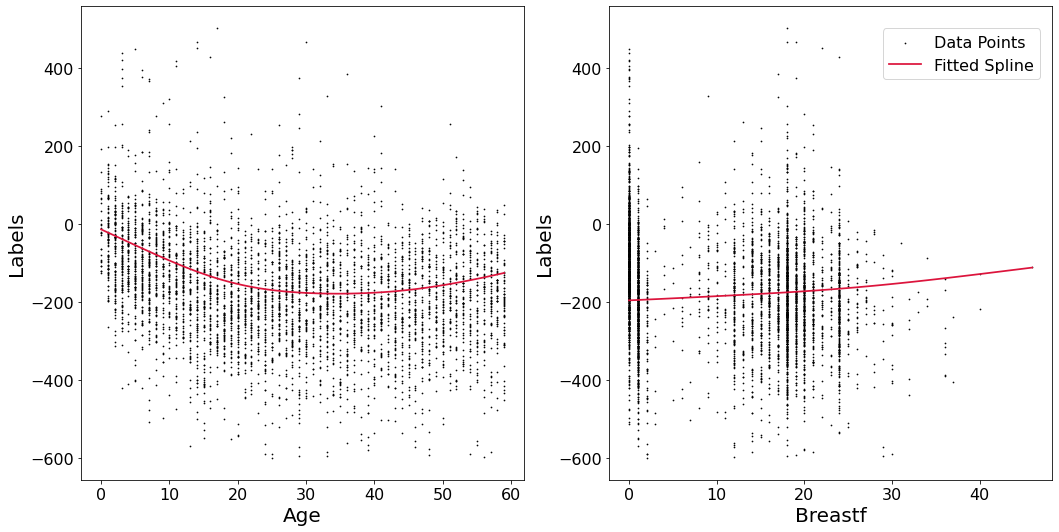

In [25]:
font_size = 20
font_size_legend = 16
font_size_ticks = 16
font_size_small = 18

x1_plot = np.linspace(c_age_d.min(), c_age_d.max(), num=100)
x2_plot = np.linspace(c_breastf_d.min(), c_breastf_d.max(), num=100)

fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))

axs[0].scatter(c_age_d, labels, marker="o", s=0.5, c="black", label="data points")

matrix_plot = sp.build_base(
    x1_plot, degree=degree_bsplines, knot_type="given", given_knots=age.knots
)[0]
y_hat = np.dot(matrix_plot, weights_x1)
axs[0].plot(
    x1_plot, y_hat + y_hat.mean(), lw=1.75, label=f"Final Result", color="crimson"
)

axs[0].set_xlabel("Age", fontsize=font_size)
axs[0].set_ylabel("Labels", fontsize=font_size)
axs[0].tick_params(labelsize=font_size_ticks)


axs[1].scatter(c_breastf_d, labels, marker="o", s=0.5, c="black", label="Data Points")

matrix_plot = sp.build_base(
    x2_plot, degree=degree_bsplines, knot_type="given", given_knots=breastf.knots
)[0]
y_hat = np.dot(matrix_plot, weights_x2)
axs[1].plot(
    x2_plot, y_hat + y_hat.mean(), lw=1.75, label=f"Fitted Spline", color="crimson"
)

axs[1].set_xlabel("Breastf", fontsize=font_size)
axs[1].set_ylabel("Labels", fontsize=font_size)
axs[1].tick_params(labelsize=font_size_ticks)
axs[1].legend(loc="center left", bbox_to_anchor=(0.6, 0.9), fontsize=font_size_legend)

fig.set_facecolor("white")
fig.tight_layout()
plt.savefig(f"Plots/multidim_zambia_spline.png", bbox_inches="tight", dpi=300)
plt.savefig(f"Plots/multidim_zambia_spline.pdf", bbox_inches="tight", dpi=300)
plt.show()